# AI vs Human Image Classification

## Setup and Configuration

In [9]:
import os
import torch
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count
import random
from PIL import Image
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch.cuda.amp import GradScaler, autocast
import torch.nn.functional as F
import torch.optim as optim
import logging
import albumentations as A
import sys
from tqdm import tqdm
import time
from sklearn.metrics import accuracy_score, classification_report
import timm
from timm import create_model
from torchvision import models
from torchvision.transforms import InterpolationMode

# sys.path.append('/kaggle/working/NaViT')  
# from navit import NaViT

# # from transformers import NavitConfig, NavitModel

logging.basicConfig(level=logging.INFO)
_logger = logging.getLogger(__name__)

import warnings

warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(42)

In [ ]:
class CFG:
    lr = 5e-4
    batch_size = 16
    img_size = (224, 224)
    model_name = 'convnextv2_large'
    seed = 42
    epochs = 15
    root_dir = '/kaggle/input/ai-vs-human-generated-dataset'
    test_df = os.path.join(root_dir, 'test.csv')
    train_df = os.path.join(root_dir, 'train.csv')
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    checkpoint_path = 'models/convnextv2_large_ai_vs_human.pth'
    train_data_path = '/kaggle/input/ai-vs-human-generated-dataset/train'  
    test_data_path = '/kaggle/input/ai-vs-human-generated-dataset/test_data_v2'
    test_csv_path = '/kaggle/input/ai-vs-human-generated-dataset/test.csv'
    submission_path = 'submission.csv'
    mixed_precision = False  
    num_workers = 2
    pin_memory = True
    weight_decay = 1e-5
    num_classes = 2
    patch_size = 32
    gamma = 0.7
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data Exploration

In [12]:
train_df = pd.read_csv(CFG.train_df)
train_df = train_df.drop(['Unnamed: 0'], axis = 1)
train_df['file_name'] = train_df['file_name'].apply(lambda x: os.path.join(CFG.root_dir, x))
train_df.head(10)

,file_name,label
0,/kaggle/input/ai-vs-human-generated-dataset/tr...,1
1,/kaggle/input/ai-vs-human-generated-dataset/tr...,0
2,/kaggle/input/ai-vs-human-generated-dataset/tr...,1
3,/kaggle/input/ai-vs-human-generated-dataset/tr...,0
4,/kaggle/input/ai-vs-human-generated-dataset/tr...,1
5,/kaggle/input/ai-vs-human-generated-dataset/tr...,0
6,/kaggle/input/ai-vs-human-generated-dataset/tr...,1
7,/kaggle/input/ai-vs-human-generated-dataset/tr...,0
8,/kaggle/input/ai-vs-human-generated-dataset/tr...,1
9,/kaggle/input/ai-vs-human-generated-dataset/tr...,0


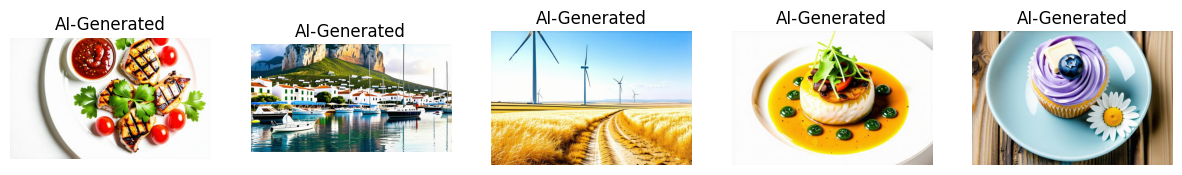

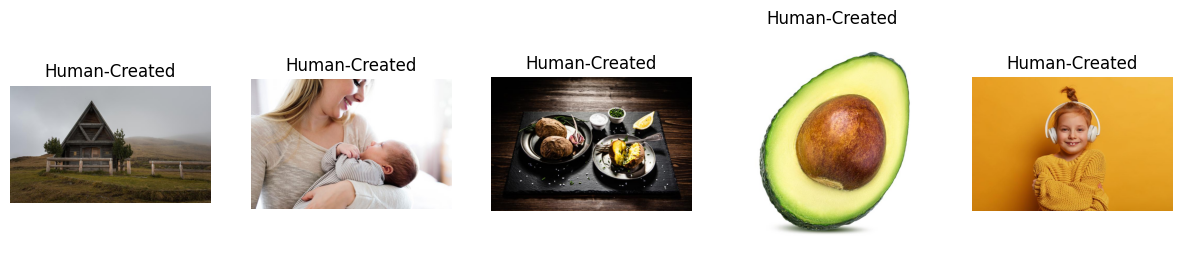

In [13]:
def plot_samples(df, num_img = 5, label = 0):
    samples = df[df['label'] == label].sample(num_img)['file_name'].values

    plt.figure(figsize = (15, 5))

    for i, path in enumerate(samples):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_img, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title("AI-Generated" if label == 1 else "Human-Created")

    plt.show()


plot_samples(train_df, label = 1)
plot_samples(train_df, label = 0)

# EDA

In [ ]:
def process_image_size(row):
    """Helper function for parallel size processing"""
    try:
        img = cv2.imread(row['file_name'], cv2.IMREAD_GRAYSCALE)
        if img is not None:
            return (row['label'], img.shape[1], img.shape[0])  
        return None
    except:
        return None

def process_image_brightness(row):
    try:
        img = cv2.imread(row['file_name'], cv2.IMREAD_GRAYSCALE)
        if img is not None:
            return (row['label'], np.mean(img))
        return None
    except:
        return None

In [ ]:
def plot_image_size_distribution(df, num_workers=None, max_images=5000):
    if num_workers is None:
        num_workers = cpu_count()  
    if len(df) > max_images:
        sampled_df = df.sample(n=max_images, random_state=42)  
    else:
        sampled_df = df
    
    with Pool(num_workers) as pool:
        results = pool.map(process_image_size, [row for _, row in sampled_df.iterrows()])
    
    results = [r for r in results if r is not None]
    human_widths = [r[1] for r in results if r[0] == 0]
    human_heights = [r[2] for r in results if r[0] == 0]
    ai_widths = [r[1] for r in results if r[0] == 1]
    ai_heights = [r[2] for r in results if r[0] == 1]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    sns.histplot(human_widths, ax=ax1, color='blue', label='Human', alpha=0.5)
    sns.histplot(ai_widths, ax=ax1, color='red', label='AI', alpha=0.5)
    ax1.set_title(f'Width Distribution (Max {max_images} Images)')
    ax1.set_xlabel('Width (pixels)')
    ax1.legend()
    
    sns.histplot(human_heights, ax=ax2, color='blue', label='Human', alpha=0.5)
    sns.histplot(ai_heights, ax=ax2, color='red', label='AI', alpha=0.5)
    ax2.set_title(f'Height Distribution (Max {max_images} Images)')
    ax2.set_xlabel('Height (pixels)')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_brightness_distribution(df, num_workers=None, max_images=5000):
    if num_workers is None:
        num_workers = cpu_count()  
    if len(df) > max_images:
        sampled_df = df.sample(n=max_images, random_state=42)  
    else:
        sampled_df = df
    
    with Pool(num_workers) as pool:
        results = pool.map(process_image_brightness, [row for _, row in sampled_df.iterrows()])
    
    results = [r for r in results if r is not None]
    human_brightness = [r[1] for r in results if r[0] == 0]
    ai_brightness = [r[1] for r in results if r[0] == 1]
    
    plt.figure(figsize=(10, 6))
    
    sns.histplot(human_brightness, color='blue', label='Human', alpha=0.5)
    sns.histplot(ai_brightness, color='red', label='AI', alpha=0.5)
    
    plt.title(f'Brightness Distribution by Class (Max {max_images} Images)')
    plt.xlabel('Mean Brightness (0-255)')
    plt.ylabel('Count')
    
    human_mean = np.mean(human_brightness)
    ai_mean = np.mean(ai_brightness)
    plt.axvline(human_mean, color='blue', linestyle='--', label=f'Human Mean: {human_mean:.1f}')
    plt.axvline(ai_mean, color='red', linestyle='--', label=f'AI Mean: {ai_mean:.1f}')
    
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
plot_image_size_distribution(train_df, max_images = 5000)
plot_brightness_distribution(train_df, max_images = 5000)

## Data Preprocessing

### Data Augmentation and Transformations

In [19]:
train_transforms = v2.Compose([
    v2.Resize(224, interpolation=InterpolationMode.BICUBIC),
    v2.RandomCrop(224),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToTensor(),
    # v2.Lambda(lambda x: A.CoarseDropout(max_holes=4, max_height=16, max_width=16, p=0.5)(image=np.array(x))["image"]),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
])

test_transforms = v2.Compose([
    v2.Resize(224, interpolation=InterpolationMode.BICUBIC),
    v2.ToTensor(),
    v2.CenterCrop(224),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


### Dataset Class Implementation

In [20]:
class AIvsHumanDataset(Dataset):
    def __init__(self, df, transforms=None, is_test=False):
        self.df = df
        self.transforms = transforms
        self.is_test = is_test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['file_name']
        img = Image.open(img_path).convert('RGB')
        
        if self.transforms:
            img = self.transforms(img)
            
        if self.is_test:
            return img
        else:
            label = self.df.iloc[idx]['label']  
            return img, label

### Train-Validation Split

In [22]:
train_df, val_df = train_test_split(
    train_df,  
    test_size=0.05,        
    stratify=train_df['label'],  
    random_state=42
)

## Model Development

### Model Architecture

In [14]:
def create_convnext_model():
    model = models.convnext_large(weights=models.ConvNeXt_Large_Weights.IMAGENET1K_V1)
    num_ftrs = model.classifier[2].in_features
    model.classifier[2] = nn.Linear(num_ftrs, 2)
    model.to(CFG.device)
    
    return model

In [15]:
def create_regnet_model():
    model = models.regnet_y_32gf(weights=models.RegNet_Y_32GF_Weights.IMAGENET1K_SWAG_E2E_V1)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)
    model.to(CFG.device)
    
    return model

### Training Functions

In [ ]:
def train_one_epoch(model, loader, optimizer, criterion, device, scaler=None):
    model.train()
    train_loss = 0.0
    preds_list = []
    labels_list = []
    
    pbar = tqdm(loader, desc="Training")
    for images, labels in pbar:
        images, labels = images.to(CFG.device), labels.to(CFG.device)
        
        if CFG.mixed_precision and scaler is not None:
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
        optimizer.zero_grad()
        
        train_loss += loss.item() * images.size(0)
        
        _, preds = torch.max(outputs, 1)
        preds_list.append(preds.cpu().numpy())
        labels_list.append(labels.cpu().numpy())
        
        pbar.set_postfix({'batch_loss': loss.item()})
    
    train_loss = train_loss / len(loader.dataset)
    preds_all = np.concatenate(preds_list)
    labels_all = np.concatenate(labels_list)
    accuracy = accuracy_score(labels_all, preds_all)
    
    return train_loss, accuracy

def validate(model, loader, criterion, device):
    model.eval()
    val_loss = 0.0
    preds_list = []
    labels_list = []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validation"):
            images, labels = images.to(CFG.device), labels.to(CFG.device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
            
            _, preds = torch.max(outputs, 1)
            preds_list.append(preds.cpu().numpy())
            labels_list.append(labels.cpu().numpy())
    
    val_loss = val_loss / len(loader.dataset)
    preds_all = np.concatenate(preds_list)
    labels_all = np.concatenate(labels_list)
    accuracy = accuracy_score(labels_all, preds_all)

    _logger.info(f'\nClassification Report:\n{classification_report(labels_all, preds_all)}')
    
    return val_loss, accuracy

In [ ]:
def train_model(train_df, val_df):
    train_dataset = AIvsHumanDataset(df=train_df, transforms=train_transforms)
    val_dataset = AIvsHumanDataset(df=val_df, transforms=test_transforms)
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=CFG.batch_size, 
        shuffle=True, 
        num_workers=CFG.num_workers, 
        pin_memory=CFG.pin_memory
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=CFG.batch_size, 
        shuffle=False, 
        num_workers=CFG.num_workers, 
        pin_memory=CFG.pin_memory
    )
    
    model = create_regnet_model()
    model.to(CFG.device)

    # all_params = list(model.named_parameters())
    # total_params = len(all_params)
    # freeze_until = total_params - 10  # Keep the last 10 trainable
    
    # for idx, (name, param) in enumerate(all_params):
    #     if idx < freeze_until:
    #         param.requires_grad = False
    #     else:
    #         param.requires_grad = True
    
    # for name, param in model.named_parameters():
    #     _logger.info(f"Layer: {name}, Requires Grad: {param.requires_grad}")
    
    criterion = nn.CrossEntropyLoss().to(CFG.device)
    optimizer = optim.Adam(
        model.parameters(), 
        lr=5e-5, 
        weight_decay=CFG.weight_decay
    )
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, 
        step_size = 1,
        gamma = CFG.gamma
    )
    
    scaler = GradScaler() if CFG.mixed_precision else None
    
    best_val_acc = 0.0
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    
    for epoch in range(CFG.epochs):
        _logger.info(f'Epoch {epoch+1}/{CFG.epochs}')
        
        train_loss, train_acc = train_one_epoch(
            model, train_loader, optimizer, criterion, CFG.device, scaler
        )
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        val_loss, val_acc = validate(model, val_loader, criterion, CFG.device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        scheduler.step()
        
        _logger.info(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        _logger.info(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            _logger.info(f'Saving best model with accuracy: {best_val_acc:.4f}')
            
            os.makedirs(os.path.dirname(CFG.checkpoint_path), exist_ok=True)
            
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
                'best_val_acc': best_val_acc,
                'train_losses': train_losses,
                'val_losses': val_losses,
                'train_accs': train_accs,
                'val_accs': val_accs,
            }, CFG.checkpoint_path)
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Val Accuracy')
    plt.title('Accuracy vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_curves.png')
    plt.show()
    
    return model, best_val_acc

## Model Inference and Visualization

### Prediction Visualization

In [ ]:
def plot_predictions(images, predictions, num_images=20):
    num_images = min(len(images), num_images)
    
    rows = (num_images + 4) // 5  
    
    fig, axes = plt.subplots(rows, 5, figsize=(20, 4 * rows))
    axes = axes.flatten()
    
    for i in range(num_images):
        img = images[i].permute(1, 2, 0).numpy()
        
        # Denormalize if needed
        # img = img * std + mean

        img = np.clip(img, 0, 1)
        
        axes[i].imshow(img)
        axes[i].set_title(f"Predicted: {'AI' if predictions[i] == 1 else 'Human'}")
        axes[i].axis('off')

    for i in range(num_images, len(axes)):
        axes[i].axis('off')
        
    plt.tight_layout()
    plt.show()

In [ ]:
def create_submission(model, test_csv_path, test_data_path):
    test_df = pd.read_csv(test_csv_path)
    
    test_df['file_name'] = test_df['id'].apply(lambda x: os.path.join(test_data_path, x))
    test_dataset = AIvsHumanDataset(df=test_df, transforms=test_transforms, is_test=True)
    test_loader = DataLoader(
        test_dataset, 
        batch_size=CFG.batch_size, 
        shuffle=False, 
        num_workers=CFG.num_workers, 
        pin_memory=CFG.pin_memory
    )
    
    model.eval()
    predictions = []
    all_images = []  
    
    with torch.no_grad():
        for images in tqdm(test_loader, desc="Predicting"):
            images = images.to(CFG.device)
            
            outputs = model(images)
            probabilities = F.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            predictions.extend(preds.cpu().numpy().tolist())
            all_images.extend(images.cpu())  
            
    submission_df = pd.DataFrame({
        'id': test_df['id'],
        'label': predictions
    })
    
    submission_df.to_csv(CFG.submission_path, index=False)
    _logger.info(f"Submission file created at {CFG.submission_path}")
    
    plot_predictions(all_images, predictions, num_images=20)
    
    return submission_df

In [ ]:
model, _ = train_model(train_df, val_df)

Predicting: 100%|██████████| 347/347 [01:35<00:00,  3.65it/s]


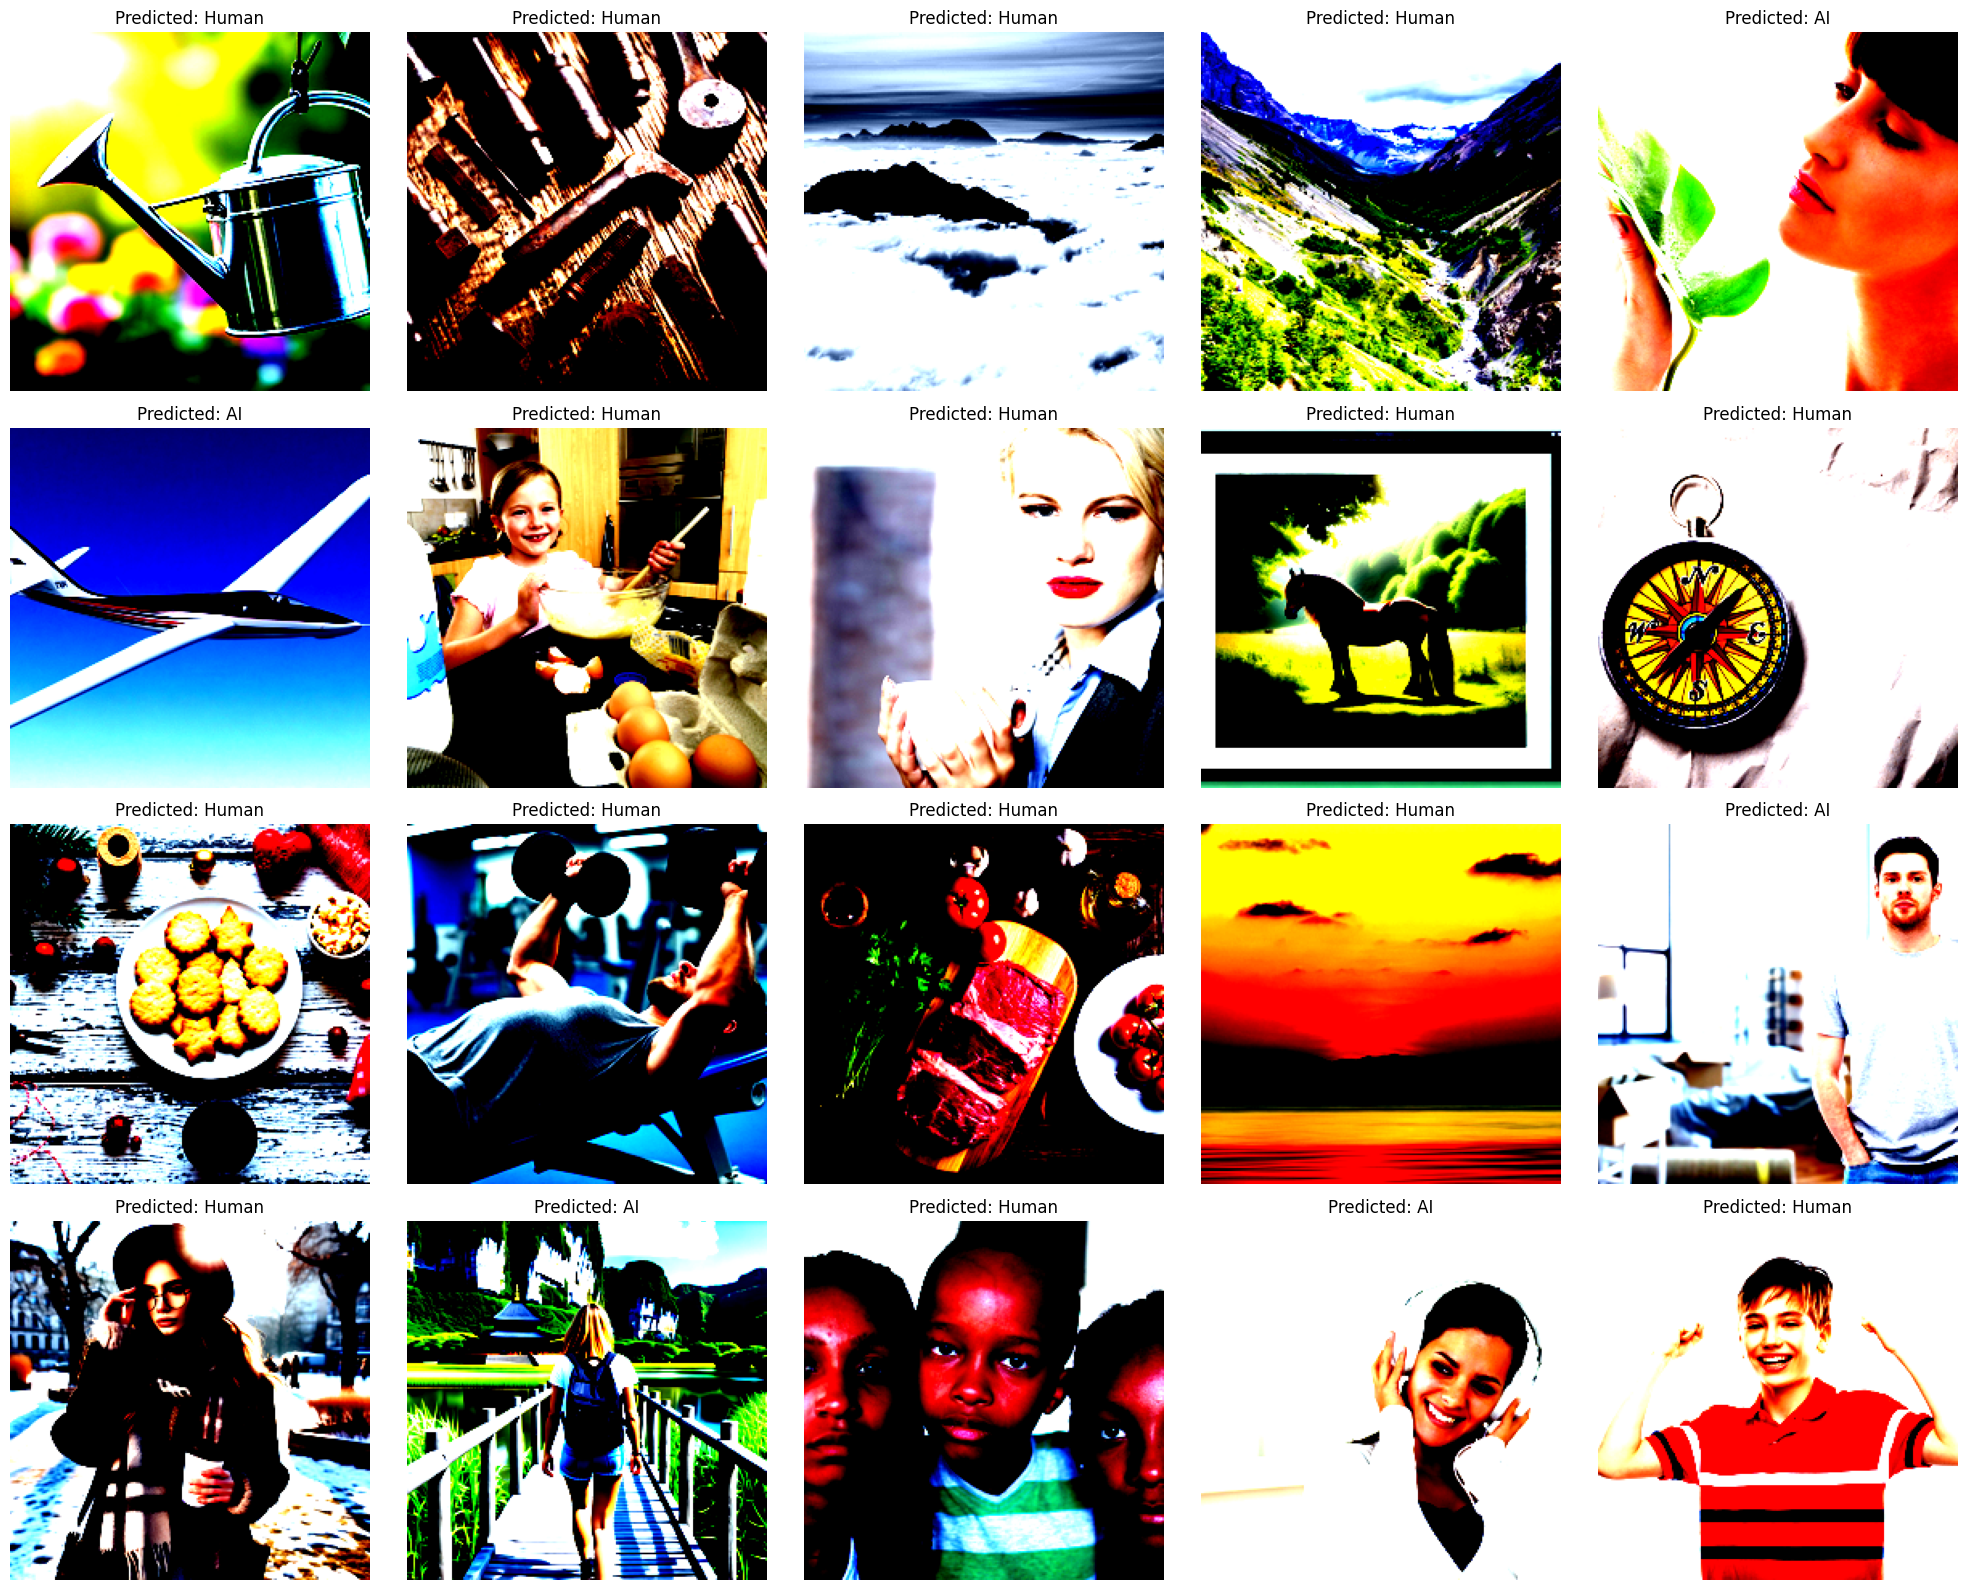

In [23]:
submission = create_submission(model, '/kaggle/input/ai-vs-human-generated-dataset/test.csv', '/kaggle/input/ai-vs-human-generated-dataset')

### Submission Generation

In [24]:
submission.to_csv('/kaggle/working/submission.csv', index=False)